In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import xarray as xr
import seaborn as sns
import statsmodels.api as sm

from matplotlib.colors import Normalize, to_hex

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Set seed
seed = 8888
rng = np.random.default_rng(seed)

# Get point colours from colourmap
norm = Normalize(vmin=-0.5, vmax=1.5)
cmap1 = plt.get_cmap('Greys')
cmap2 = plt.get_cmap('Reds')

# Map each scalar to a color
blacks = [to_hex(cmap1(norm(value))) for value in [0,1]]
reds = [to_hex(cmap2(norm(value))) for value in [0,1]]

# 1. State a clear question
- What is the causal effect of $X$ on $Y$? $U$ is an unobserved confound (fork) that is mediate to $X$ through $Z$.

# 2. Sketch out the causal assumptions (DAG) of the model
X → Y  
↑    
Z  
↑ &nbsp; ↗  
u

# 3. Define a generative model
### Generate data
Here, we generate synthetic data based on causal assumptions of our system and visualise these data.

In [3]:
N = 200
b_xy = 0
b_uy = -1
b_uz = -1
b_zx = 1

U = rng.binomial(1, 0.5, size=N)
Z = rng.normal(b_uz * U, 1, size=N)
X = rng.normal(b_zx * Z, 1, size=N)
Y = rng.normal(b_xy * X + b_uy * U, 1, size=N)
sim_data = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

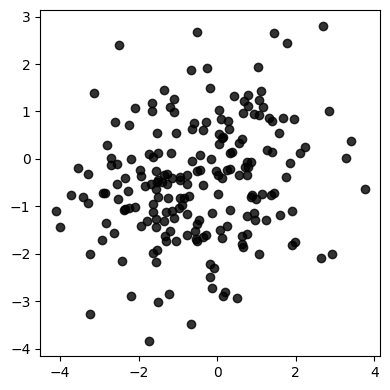

In [4]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(sim_data['X'], sim_data['Y'], c='black', alpha=0.8)

plt.tight_layout()
plt.show()

# 4. Design a statistical way to build the estimator using the generative model
### Fit model to generated data ignoring U and Z

In [5]:
with pm.Model() as model_xy:
    # Define priors
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta_x = pm.Normal('beta_x', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Define likelihood
    Y_obs = pm.Normal('Y_obs', mu=alpha + beta_x * sim_data['X'], sigma=sigma, observed=sim_data['Y'].values)
    
    # Inference
    idata_xy = pm.sample(1000)
    
az.summary(idata_xy)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_x, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.385,0.090,-0.554,-0.214,0.001,0.001,4977.0,3296.0,1.0
beta_x,0.155,0.055,0.051,0.257,0.001,0.001,4986.0,3150.0,1.0
sigma,1.218,0.061,1.103,1.333,0.001,0.001,5824.0,3213.0,1.0


In [6]:
with pm.Model() as model_xyz:
    # Define priors
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta_x = pm.Normal('beta_x', mu=0, sigma=1)
    beta_z = pm.Normal('beta_z', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    
    # Define likelihood
    Y_obs = pm.Normal('Y_obs', mu=alpha + beta_x * sim_data['X'] + beta_z * sim_data['Z'], sigma=sigma, observed=sim_data['Y'].values)
    
    # Inference
    idata_xyz = pm.sample(1000)
    
az.summary(idata_xyz)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_x, beta_z, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.348,0.093,-0.532,-0.184,0.002,0.001,3293.0,2851.0,1.0
beta_x,0.044,0.081,-0.114,0.192,0.001,0.001,3186.0,2618.0,1.0
beta_z,0.197,0.109,-0.012,0.399,0.002,0.002,3062.0,2294.0,1.0
sigma,1.211,0.061,1.099,1.323,0.001,0.001,3683.0,3187.0,1.0


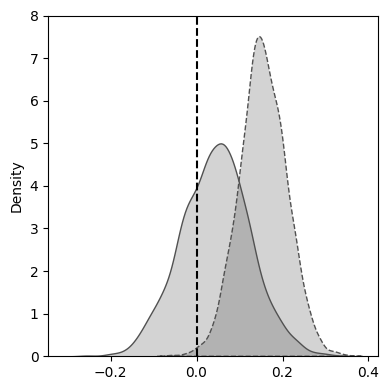

In [7]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

sns.kdeplot(idata_xy.posterior['beta_x'].values.reshape(-1), color=blacks[1], fill=True, alpha=0.6, linestyle='dashed', ax=ax)
sns.kdeplot(idata_xyz.posterior['beta_x'].values.reshape(-1), color=blacks[1], fill=True, alpha=0.6, ax=ax)

ax.vlines(x=0, ymin=0, ymax=8, color='black', linestyle='dashed')
ax.set_ylim(0,8)

plt.tight_layout()
plt.show()

Here, we see that stratifying on $Z$ helps us recover the effect of $X$ on $Y$. As in the input of our simulated data, model_xyz performs better than model_xy. Ideally, this is not the effect we're after. We should marginalise over $Z$ to obtain the causal effect of $X$ on the $Y$ distribution.

Another thing worth noting here is that $b_z$ has an all positive posterior distribution. THis however is meaningless and does not represent the effect of $Z$ on $Y$. Why is this so? Well, because there is no arrow that goes from $Z$ to $Y$ in our DAG.

# Example DAGs
X → Z → Y  
&nbsp; &nbsp; &nbsp; &nbsp; ↑ ↗    
&nbsp; &nbsp; &nbsp; &nbsp; u

In [56]:
def sim_DAG(N=100, b_xz=1, b_zy=1):
    X = rng.normal(size=N)
    u = rng.normal(size=N)
    Z = rng.normal(b_xz * X + u, 1, size=N)
    Y = rng.normal(b_zy * Z + u, 1, size=N)
    
    sim_data = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})
    
    b_X = sm.OLS(Y, sim_data[['X']]).fit().params['X']
    b_XZ = sm.OLS(Y, sim_data[['X', 'Z']]).fit().params['X']

    return b_X, b_XZ

In [57]:
n_sims = 1000

b_X = np.zeros(n_sims,)
b_XZ = np.zeros(n_sims,)

for i in range(n_sims):
    b_X[i], b_XZ[i] = sim_DAG()

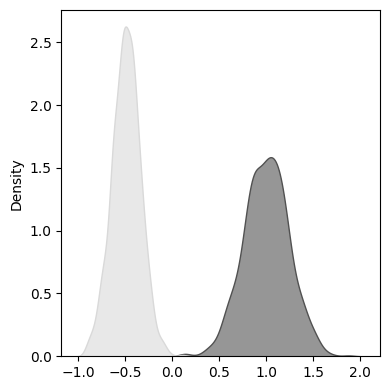

In [58]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

sns.kdeplot(b_X, color=blacks[1], fill=True, alpha=0.6, ax=ax)
sns.kdeplot(b_XZ, color=blacks[0], fill=True, alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()

For this specific DAG, we set the causal effect of $X$ on $Y$ to $1$. We see that in this case, stratifying the data by $Z$ gives us the wrong estimate for this effect. This happens because stratifying by $Z$ opens the door to the unobserved variables $U$. In this case, you cannot measure the mediation effect of $Z$ as this would result in confounds with $U$.

&nbsp; &nbsp; &nbsp; &nbsp; Z  
&nbsp; &nbsp; &nbsp; &nbsp; ↑  
X → Y

In [24]:
def sim_DAG(N=100, b_xy=1, b_yz=1):
    X = rng.normal(size=N)
    Y = rng.normal(b_xy * X, 1, size=N)
    Z = rng.normal(b_yz * Y, 1, size=N)
    
    sim_data = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})
    
    b_X = sm.OLS(Y, sim_data[['X']]).fit().params['X']
    b_XZ = sm.OLS(Y, sim_data[['X', 'Z']]).fit().params['X']

    return b_X, b_XZ

In [25]:
n_sims = 1000

b_X = np.zeros(n_sims,)
b_XZ = np.zeros(n_sims,)

for i in range(n_sims):
    b_X[i], b_XZ[i] = sim_DAG()

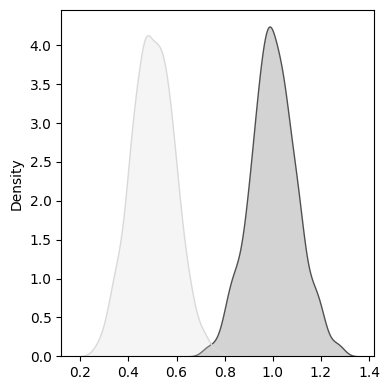

In [26]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

sns.kdeplot(b_X, color=blacks[1], fill=True, alpha=0.6, ax=ax)
sns.kdeplot(b_XZ, color=blacks[0], fill=True, alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()

Once again, we see that stratifying by $Z$ causes this specific DAG to give the wrong posterior for the causal effect of $X$ on $Y$. Hence, it is a bad idea to stratify the model by a variable that is a descendent of the outcome variable, here $Y$.

Similarly, we should also not condition our model by an ancestor of the input variable, here $X$. This reduces precision of our estimate.

Z  
↓  
X → Y

In [44]:
def sim_DAG(N=100, b_zx=1, b_xy=1):
    Z = rng.normal(size=N)
    X = rng.normal(b_zx * Z, 1, size=N)
    Y = rng.normal(b_xy * X, 1, size=N)
    
    sim_data = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})
    
    b_X = sm.OLS(Y, sim_data[['X']]).fit().params['X']
    b_XZ = sm.OLS(Y, sim_data[['X', 'Z']]).fit().params['X']

    return b_X, b_XZ

In [45]:
n_sims = 1000

b_X = np.zeros(n_sims,)
b_XZ = np.zeros(n_sims,)

for i in range(n_sims):
    b_X[i], b_XZ[i] = sim_DAG()

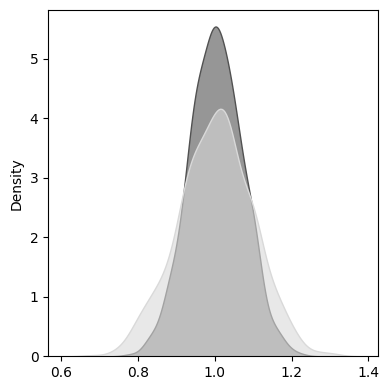

In [46]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

sns.kdeplot(b_X, color=blacks[1], fill=True, alpha=0.6, ax=ax)
sns.kdeplot(b_XZ, color=blacks[0], fill=True, alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()

We will now take the same DAG as above and add unobserved variables to it.

Z &nbsp; u   
↓ ↙↘   
X → Y

In [53]:
def sim_DAG(N=100, b_zx=1, b_xy=0):
    Z = rng.normal(size=N)
    u = rng.normal(size=N)
    X = rng.normal(b_zx * Z + u, 1, size=N)
    Y = rng.normal(b_xy * X + u, 1, size=N)
    
    sim_data = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})
    
    b_X = sm.OLS(Y, sim_data[['X']]).fit().params['X']
    b_XZ = sm.OLS(Y, sim_data[['X', 'Z']]).fit().params['X']

    return b_X, b_XZ

In [54]:
n_sims = 1000

b_X = np.zeros(n_sims,)
b_XZ = np.zeros(n_sims,)

for i in range(n_sims):
    b_X[i], b_XZ[i] = sim_DAG()

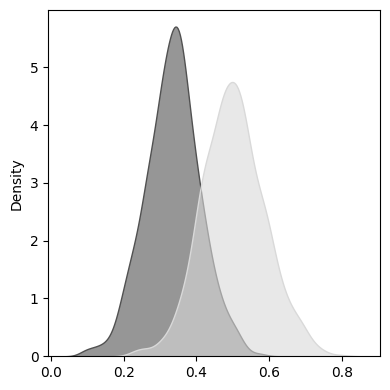

In [55]:
fig,ax = plt.subplots(1,1, figsize=(4,4))

sns.kdeplot(b_X, color=blacks[1], fill=True, alpha=0.6, ax=ax)
sns.kdeplot(b_XZ, color=blacks[0], fill=True, alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()